## stitching contrasts together in different ways

We'd want:

 - contrast of the two conditions
 - each of the two conditions alone.
 
The contrast is a little tricky. Easiest thing is to try each of the conditions alone. Stitching the two together might not be too hard. Let's try doing CorrectStop first, and then we'll try concatenating the images. Doing a contrast is actually the most difficult becuase I have to backtrack in the process to generate new betas (see https://docs.google.com/presentation/d/1K-nFrZYE6rR8t0myNyacB7frBzV3B1--nMqPhVkwL8E/edit#slide=id.geeff6890fb_0_16).

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../../ml/"))

import scipy.io
import re
from dev_wtp_io_utils import get_Brain_Data_betas_for_sub
import pandas as pd

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
import numpy as np

In [4]:
from nilearn import plotting
from nilearn.masking import compute_brain_mask
import nltools as nlt
import nilearn as nil

from import_sst_cond_w1_subjs_to_pkl:

In [5]:
#load the matrix associated with this file
first_level_path='/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions'
sl_mat = scipy.io.loadmat(first_level_path + '/sub-DEV073/SPM.mat',
simplify_cells=True            
)
mat_betas = sl_mat['SPM']['Vbeta']

In [6]:
sl='DEV073'

In [7]:
beta_dict_list = []
mat_betas = sl_mat['SPM']['Vbeta']
for beta_i in range(len(mat_betas)):
    beta = mat_betas[beta_i]
    b_description = beta['descrip']
    condition_label = re.search('Sn\(1\)\s(.*)\*bf\(1\)',b_description)
    if (condition_label is not None):
        beta_dict_list = beta_dict_list + [{
            'condition_index':beta_i,
            'condition_label':condition_label.group(1),
            'raw_beta_description':beta['descrip'],
            'beta':beta['fname']
        }]
        
beta_df = pd.DataFrame(beta_dict_list)

        
beta_df['subject']=sl
beta_df['wave']=1

In [8]:
bd = get_Brain_Data_betas_for_sub(
    sl, beta_df,
    betaseries_path = first_level_path + "/",
    events_in_design=beta_df.shape[0],
    mask = "beta" # '/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain_mask.nii'
)

.......verified that all expected betas exist! Processing...setting the mask to the first image in the series beta_0001.nii
temp mask created.
loading files. This step may take some time...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   
2                2      FailedStop   
3                3             Cue   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV073     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV073     1  
2   spm_spm:beta (0003) - Sn(1) FailedStop*bf(1)  beta_0003.nii  DEV073     1  
3          spm_spm:beta (0004) - Sn(1) Cue*bf(1)  beta_0004.nii  DEV073     1  
...imported data.
temp mask deleted


Now let's say we want to concatenate all of these together. how would we do it?

First let's visualize so we have an idea of what we're looking at.

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()



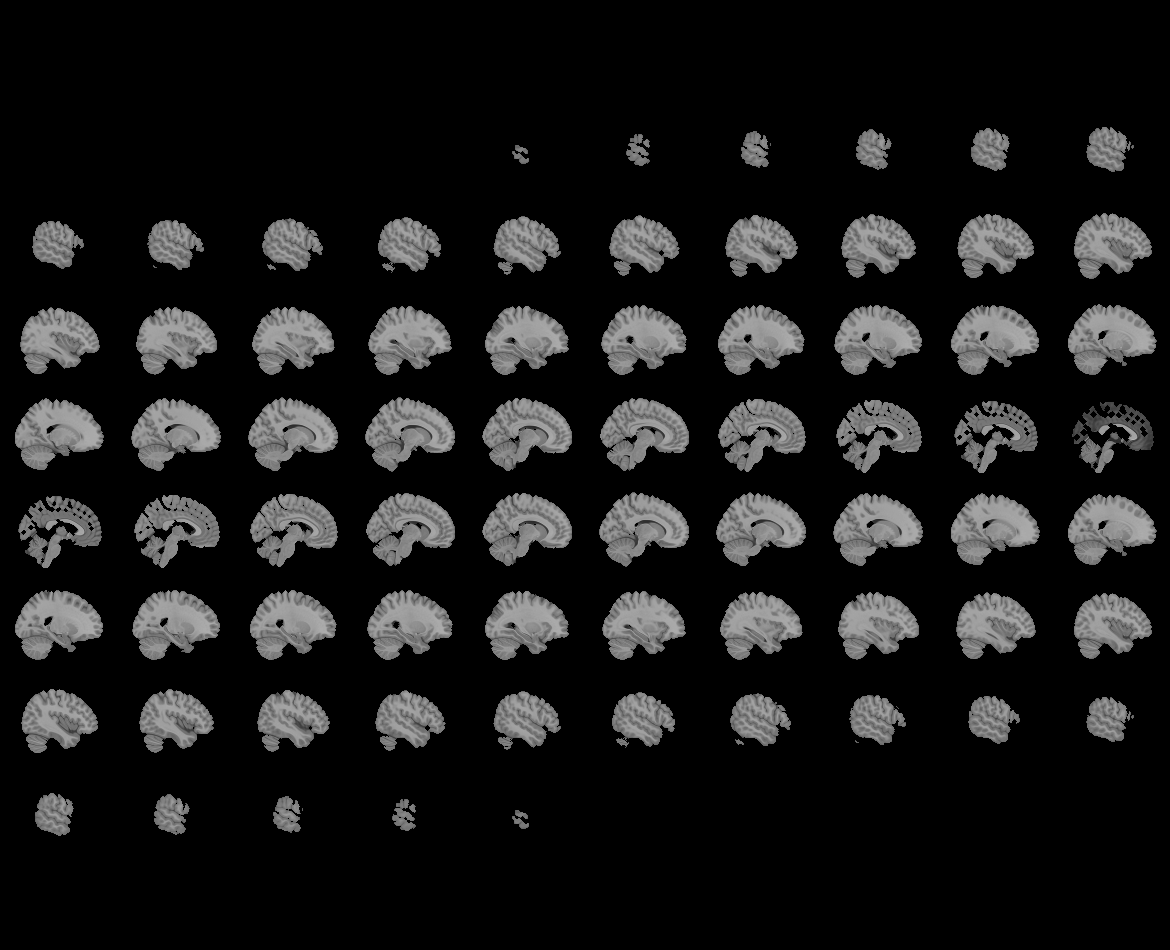
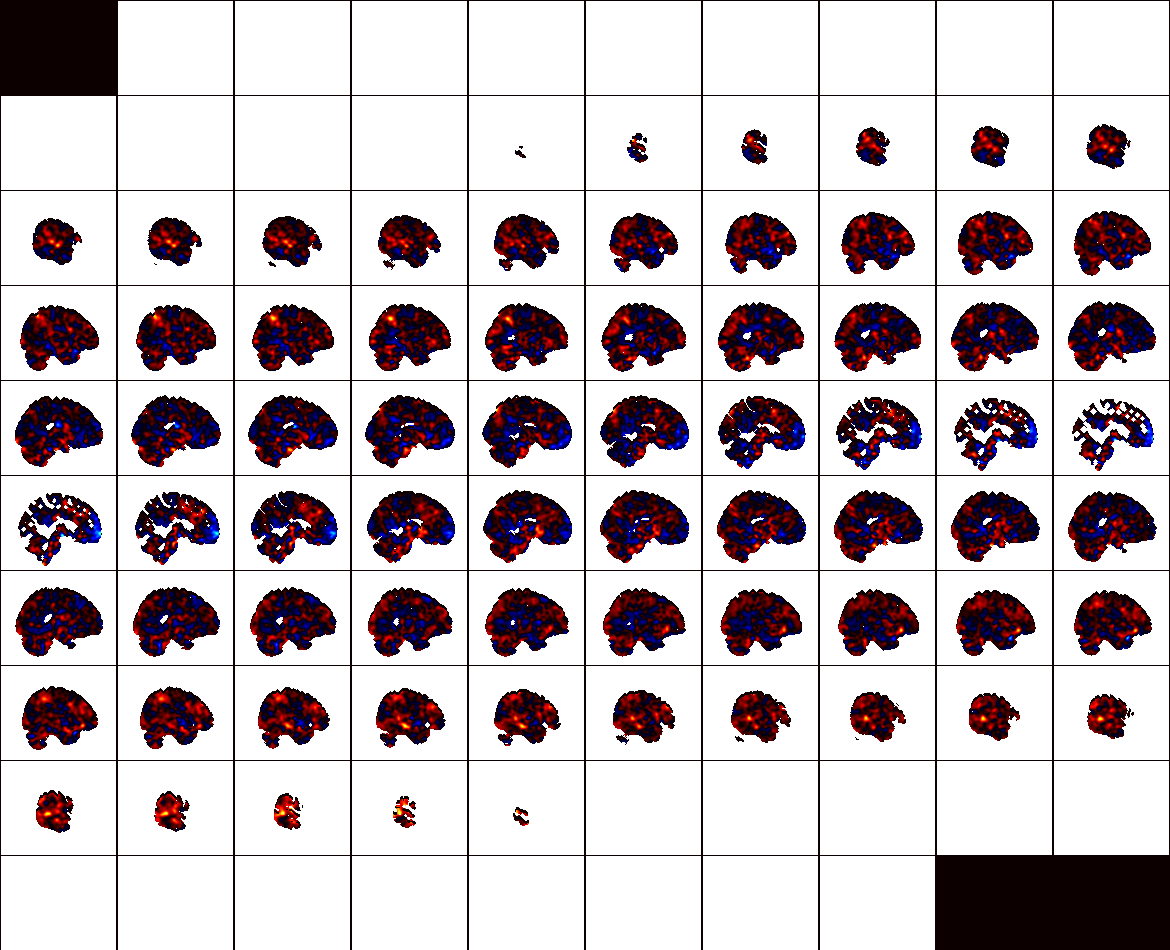

In [9]:


plotting.view_img(bd[1,].to_nifti(),threshold=0.0002)



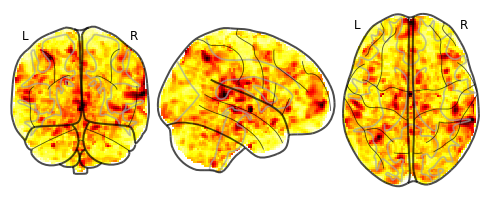

In [10]:
plotting.plot_glass_brain(bd[1,].to_nifti())

In [11]:
bd1_as_array = bd[1,].to_nifti().get_fdata()
bd2_as_array = bd[2,].to_nifti().get_fdata()

In [12]:
np.concatenate([bd1_as_array,bd2_as_array],axis=0).shape

(194, 115, 97)

In [13]:
import nilearn

In [14]:
nifti_from_array = nilearn.image.new_img_like(bd[2,].to_nifti(),bd1_as_array)

In [15]:
nifti_from_concat_array = nilearn.image.new_img_like(bd[2,].to_nifti(),np.concatenate([bd1_as_array,bd2_as_array],axis=0))

In [16]:
nifti_from_concat_array

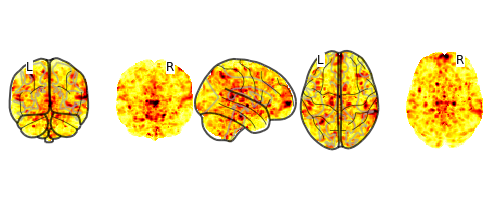

In [17]:
plotting.plot_glass_brain(nifti_from_concat_array)

That's pretty great. To do the learning, I think all we need is to be able to create concatenated masks along with it. Presumably that's not too hard?

In [20]:
def sagittal_concatenate(nifti_img):
    ###
    ###Concatenates an image on 'axis 0' of nifti, effectively placing a copy of the image on the left of the original image.
    ###the affine and spatial characteristics of the image are unchanged
    ###
    np_array = nifti_img.get_fdata()
    np_concat = np.concatenate([np_array,np_array],axis=0)
    nifti_concatenated = nil.image.new_img_like(nifti_img,np_concat)
    return(nifti_concatenated)

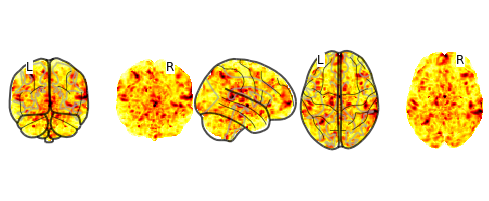

In [21]:
plotting.plot_glass_brain(sagittal_concatenate(bd[1,].to_nifti()))


In [18]:
nlt.Brain_Data(sagittal_concatenate(bd[1,].to_nifti()))

NameError: name 'sagittal_concatenate' is not defined

## Concatenated whole-brain

Don't really need this because we can and do just use the image as its own mask. But let's try...

In [ ]:
canonical_whole_brain = nil.image.load_img('/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain_mask.nii')

In [ ]:
plotting.view_img(canonical_whole_brain)

In [ ]:
concatenated_whole_brain = sagittal_concatenate(canonical_whole_brain)

In [ ]:
plotting.plot_glass_brain(concatenated_whole_brain)

## Concatenated mask

In [ ]:

acc_mask = nil.image.load_img(
    '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/masks/response_inhibition_related/harvardoxford/' + 
    'harvardoxford-cortical_prob_Cingulate Gyrus, anterior division.nii.gz'
)

In [ ]:
concatenated_acc = sagittal_concatenate(acc_mask)
concatenated_acc

In [ ]:
plotting.plot_glass_brain(concatenated_acc)

## Can we make it work for a beta series?

In [ ]:
def sagittal_concatenate(nifti_img):
    ###
    ###Concatenates an image on 'axis 0' of nifti, effectively placing a copy of the image on the left of the original image.
    ###the affine and spatial characteristics of the image are unchanged
    ###
    np_array = nifti_img.get_fdata()
    np_concat = np.concatenate([np_array,np_array],axis=0)
    nifti_concatenated = nil.image.new_img_like(nifti_img,np_concat)
    return(nifti_concatenated)

In [ ]:
np_concat = np.concatenate([bd.to_nifti().get_fdata(),bd.to_nifti().get_fdata()],axis=0)

In [ ]:
series_concatenated = sagittal_concatenate(bd.to_nifti())

In [ ]:
series_concatenated.shape

In [ ]:
plotting.plot_glass_brain(nil.image.index_img(series_concatenated,2))

OK, great. Now we can concatenate, I think we need to write a script that takes the Go and NoGo for each subject and concatenates them into a single image.
Might be best to do this at the place where we actually gather the images, i.e., `load_multisubject_brain_data_sst_w1-conditions.ipynb`.

In [ ]:
bd.X

## How about concatenating bd just as it is?

In [19]:
bd_fdata = bd.to_nifti().get_fdata()
#fdata_reshaped = np.reshape(bd_fdata,[bd_fdata.shape[0]*bd_fdata.shape[3],bd_fdata.shape[1],bd_fdata.shape[2]])


In [20]:
bd_reshaped_2 = np.concatenate([bd_fdata[:,:,:,i] for i in range(bd_fdata.shape[3])],axis=0)

In [21]:
concatenated = nil.image.new_img_like(bd.to_nifti(),bd_reshaped_2)

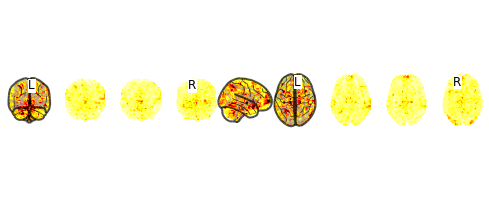

In [22]:
plotting.plot_glass_brain(concatenated)

## standarization

we have a problem with standardization. need to read in some raw files to make sense of it...

In [98]:
beta_series = nlt.Brain_Data(['/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/beta_0001.nii',
                              '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/beta_0002.nii',
                              '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/beta_0003.nii'
                             ])

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,


In [99]:
bd_nifti = beta_series.to_nifti()
bd_fdata = bd_nifti.get_fdata()
img_count = bd_fdata.shape[3]
numpy_array = np.concatenate([bd_fdata[:,:,:,i] for i in range(img_count)],axis=0)


In [100]:
#numpy_array = np.concatenate([beta1.to_nifti().get_fdata(),beta2.to_nifti().get_fdata()],axis=0)


In [101]:
numpy_array.shape

(273, 109, 91)

In [102]:
nifti_concat = nil.image.new_img_like(beta_series[1,].to_nifti(),numpy_array)

In [103]:
subj_data = nlt.Brain_Data(nifti_concat
#                          ,mask=mask
                          )

In [104]:
subj_data.to_nifti().shape

(91, 109, 91)

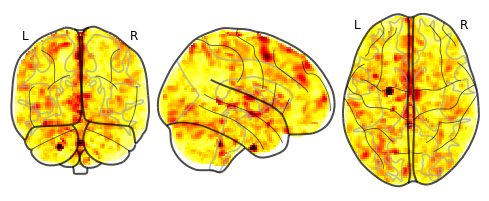

In [105]:
plotting.plot_glass_brain(subj_data.to_nifti())

In [106]:
import nibabel as nib

In [107]:
beta_based_mask = nil.masking.compute_brain_mask(beta_series[1,].to_nifti())

In [108]:
tmp="/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/"

In [109]:
img_count=2
mask_reshaped_numpy_array = np.concatenate([beta_based_mask.get_fdata()]*img_count,axis=0)
mask_reshaped = nil.image.new_img_like(beta_based_mask,mask_reshaped_numpy_array)
#mask_reshaped_bin = nil.masking.compute_brain_mask(mask_reshaped)
mask_path = tmp +"tmp_mask.nii"
nib.save(mask_reshaped,mask_path)

In [110]:
subj_data = nlt.Brain_Data(nifti_concat
                          ,mask=mask_path
                          )

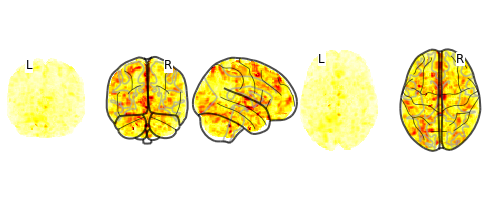

In [111]:
plotting.plot_glass_brain(subj_data.to_nifti())

# now with standardization

In [112]:
bd_nifti = nil.image.clean_img(beta_series.to_nifti(),detrend=False,standardize=True)

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


In [113]:
bd_fdata = bd_nifti.get_fdata()
img_count = bd_fdata.shape[3]
numpy_array = np.concatenate([bd_fdata[:,:,:,i] for i in range(img_count)],axis=0)


In [114]:
nifti_concat = nil.image.new_img_like(beta_series[1,].to_nifti(),numpy_array)

In [115]:
subj_data = nlt.Brain_Data(nifti_concat)

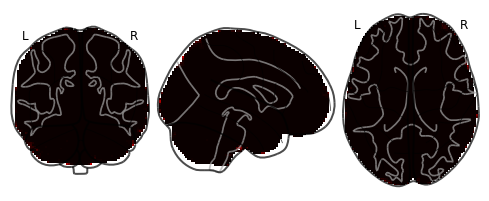

In [116]:
plotting.plot_glass_brain(subj_data.to_nifti())

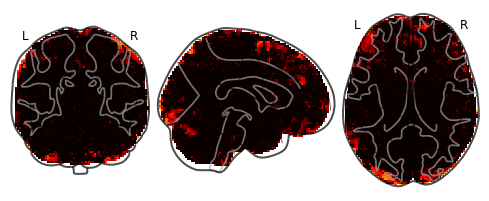

In [117]:
plotting.plot_glass_brain(bd_nifti.slicer[...,1])

I think I've discovered a very important problem in all my work by accident here.

https://github.com/nilearn/nilearn/blob/1607b524/nilearn/image/image.py#L1088
    
Seems like standardization applies to each voxel across the series, not across voxels within each image in the series.

That's why we get either -1 or 1 for every image when there's precisely two images in the series.

When there's 3 images included (as above) we start to get more variance.

This probably shouldn't be done for machine learning?

I'd always intended to standardize each _image_, right? Not each voxel. Now I know...

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


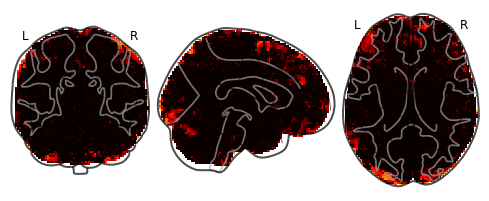

In [119]:
plotting.plot_glass_brain(beta_series.standardize(method='zscore').to_nifti().slicer[...,1])

The default in nltools does the same thing. What if we change the axis that is standardized?

For further discussion, see `standardization_issues.ipynb`.

## A way forward for spatial concatenation

We need to do axis 1 concatenation using Brain_Data (or our own normalization, which I have implemented before).

Because the data's in a numpy array, just doing it myself would be straightforward...

In [23]:
bd_fdata = bd.to_nifti().get_fdata()

In [27]:
bd_array = [bd_fdata[:,:,:,i] for i in range(bd_fdata.shape[3])]

In [33]:
print([np.mean(e) for e in bd_array])
print([np.std(e) for e in bd_array])
bd_array_zscored = [(e-np.mean(e))/np.std(e) for e in bd_array]

[0.010158278539954373, 0.041065198328171466, -0.007502289255463308, -0.06634013152074072]
[0.9349988317527402, 0.37682497450831043, 0.3573996893558657, 0.41926090215871054]


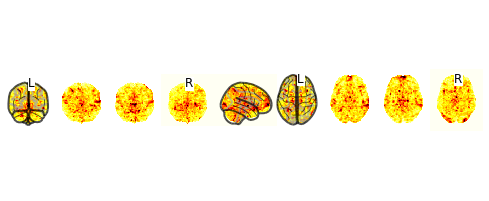

In [34]:
bd_reshaped_2 = np.concatenate(bd_array_zscored,axis=0)
concatenated = nil.image.new_img_like(bd.to_nifti(),bd_reshaped_2)
plotting.plot_glass_brain(concatenated)

That's more like what we want to see!

Although--while it makes sense for visual comparison, I dont' know if this is good for ML. Actually it's probably fine, if unnecessary--we're comparing across, not within.

Let's apply it for now, and leave a warning in code.